本教程介绍了如何使用多层模型来分析嵌套数据，以及调节效应在跨层结构中的分析方法。
我们的案例数据是日记数据（嵌套在个人中的重复事件），意思是每个人都会重复测量多次，但也适用于其他类型的嵌套数据。

# 教程目标

- 掌握嵌套数据的数据结构，并且如何构建这样的数据
- 构建多层模型（multilevel model），有人也叫多水平回归、多水平模型，但是都属于混合效应模型（Mixed effect model）
- 用多层模型分析个体间变量关系以及个体内部变量关系
- 交互效应的可视化

# 教程用到的库（请自行安装）

In [1]:
library(ggplot2)       # for 数据可视化
library(lme4)          # for 混合效应模型（多层模型）的构建
library(lmerTest)      # for 计算P值
library(psych)         # for 描述统计
library(plyr)          # for 数据整理
library(effects)       # for 检验调节效应
library(interactions)  # for 调节效应可视化

Loading required package: Matrix


Attaching package: 'lmerTest'


The following object is masked from 'package:lme4':

    lmer


The following object is masked from 'package:stats':

    step



Attaching package: 'psych'


The following objects are masked from 'package:ggplot2':

    %+%, alpha


Loading required package: carData

lattice theme set by effectsTheme()
See ?effectsTheme for details.



# 数据介绍

我们的数据来自于一个重复测量的调查研究，虽然我们没有找到关于数据的详细介绍，但是我们至少清楚我们用到的这几个变量是什么意义。
数据包含两个文件"daily-data.csv"和"person-data.csv"， 这两个文件的意义就是文件名所揭示的， 第一个文件是重复测量的数据，
被试的每天汇报的数据， 第二个文件是个体的特征数据，它只采集了一次。

我们用到的变量:

- negaff: 英文全称是 daily negative affect ， 来自于重复测量的数据， 是每天采集的消极情绪数据
- stress: 变量pss的反向编码， 代表被试每天的压力， 是重复测量的数据
- bfi_n： 这是大五人格量表中的神经质变量， 它是稳定的人格特征， 所以不是重复测量数据， 属于个体层面的变量

下面我们加载两个数据，取出用到的变量：

In [2]:
pdata = read.csv("person-data.csv")
ddata = read.csv("daily-data.csv")
pdata <- pdata[ ,c("id","bfi_n")]
ddata <- ddata[ ,c("id","day","negaff","pss")]
head(pdata)


,id,bfi_n
,<int>,<dbl>
1,101,2.0
2,102,2.0
3,103,2.5
4,104,2.5
5,105,3.5
6,106,1.5


我们有必要介绍一下日测数据， 变量day记录的是第几日， 每一行数据不是被试样本， 是被试每天的数据，你可以看下面的数据，
这种格式的数据叫做长格式， 用于存储重测数据的常用格式。

In [3]:
head(ddata)

,id,day,negaff,pss
,<int>,<int>,<dbl>,<dbl>
1,101,0,3.0,2.50
2,101,1,2.3,2.75
3,101,2,1.0,3.50
4,101,3,1.3,3.00
5,101,4,1.1,2.75
6,101,5,1.0,2.75


# 数据整理

#### 感知压力的反向编码

pss是感知压力， 但是数据中是分数越大压力越小， 所以我们反向编码一下，
使得分数越大压力越大。 

In [4]:
ddata$stress <- 4 - ddata$pss

psych::describe(ddata$stress)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,1,1445,1.385525,0.6843377,1.25,1.36344,0.7413,0,4,4,0.3549276,0.1266323,0.01800266


所有的变量都建议检查一下它的分布，我们可以使用直方图来看一下：

Warning message:
"Removed 13 rows containing non-finite values (`stat_bin()`)."


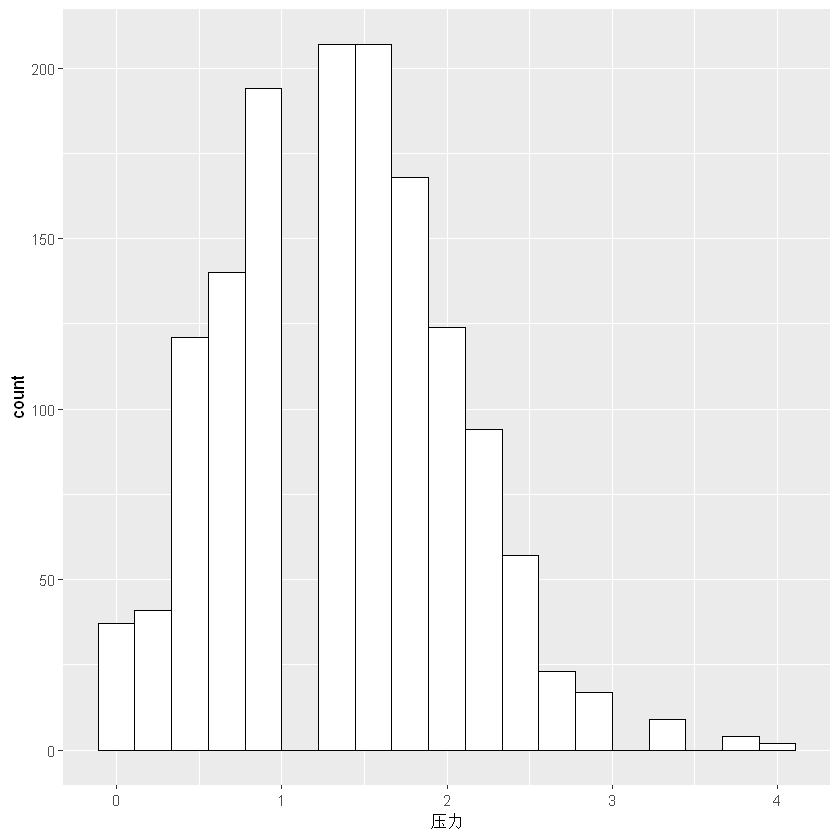

In [5]:
ggplot(data=ddata, aes(x=stress)) +
  geom_histogram(fill="white", color="black",bins=19) +
  labs(x = "压力")

#### 整理变量，划分为个体间和个体内变量

现在我们分清楚个体间变量和个体内变量， 个体间变量就是不随时间变化的，同一个个体相同的值， 不同的个体不同的值，这些变量可以称为人的特质；
个体内变量是随时间变化的， 同一个被试随着时间的变化量，这种变量可以称为状态， 因为状态是随时间变化的。

我们先要要处理的是压力（stress）这个变量， 显然它是状态变量， 但是每个人的状态都是围绕的自己的均值变化的，
所以我们可以从状态中计算个体均值， 代表他的特质， 所以新生成的变量 stress_trait 就是压力特质， 不随时间变化的变量。 我们可以这样计算这个变量：

In [6]:
# 计算个体均值
# negaff_trait虽然不是模型中的变量， 但是我们后期可能会用到它，所以也在这里一并计算了
personmeans <- ddply(ddata, "id", summarize,
                       stress_trait = mean(stress, na.rm=TRUE),
                       negaff_trait = mean(negaff, na.rm=TRUE))
head(personmeans)
describe(personmeans)

,id,stress_trait,negaff_trait
,<int>,<dbl>,<dbl>
1,101,1.06250,1.500000
2,102,0.78125,2.218750
3,103,1.25000,2.416667
4,104,1.81250,1.550000
5,105,1.75000,2.612500
6,106,1.12500,2.071875


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
id,1,190,318.294737,130.4413245,321.50000,318.993421,151.2252000,101.0000,532.0000,431.000,-0.04393582,-1.0945398,9.46320829
stress_trait,2,190,1.395533,0.4788391,1.40625,1.394792,0.5096437,0.1875,2.5625,2.375,-0.04026841,-0.2337593,0.03473864
negaff_trait,3,190,2.478309,0.7335710,2.41250,2.429841,0.7227675,1.1125,5.0875,3.975,0.67593800,0.4505905,0.05321883


In [7]:
# 将新生成的个体特质变量合并到pdata数据框, pdata 是被试样本
pdata <- merge(pdata, personmeans, by="id")                                              
# 后面我们会分析调节效应， 对变量中心化是必然的步骤，这一步就是变量中心化
pdata$bfi_n_c <- scale(pdata$bfi_n,center=TRUE,scale=FALSE)
pdata$stress_trait_c <- scale(pdata$stress_trait,center=TRUE,scale=FALSE)
# 个体数据的描述性统计
describe(pdata)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
id,1,190,3.182947e+02,130.4413245,321.50000000,3.189934e+02,151.2252000,101.000000,532.000000,431.000,-0.04393582,-1.0945398,9.46320829
bfi_n,2,190,2.981579e+00,0.9558661,3.00000000,2.996711e+00,1.4826000,1.000000,5.000000,4.000,-0.09238813,-0.8173050,0.06934582
stress_trait,3,190,1.395533e+00,0.4788391,1.40625000,1.394792e+00,0.5096437,0.187500,2.562500,2.375,-0.04026841,-0.2337593,0.03473864
negaff_trait,4,190,2.478309e+00,0.7335710,2.41250000,2.429841e+00,0.7227675,1.112500,5.087500,3.975,0.67593800,0.4505905,0.05321883
bfi_n_c,5,190,1.683047e-16,0.9558661,0.01842105,1.513158e-02,1.4826000,-1.981579,2.018421,4.000,-0.09238813,-0.8173050,0.06934582
stress_trait_c,6,190,1.927149e-17,0.4788391,0.01071742,-7.409148e-04,0.5096437,-1.208033,1.166967,2.375,-0.04026841,-0.2337593,0.03473864


将个体数据合并到重复测量的日测数据

In [8]:

ddata_long <- merge(ddata,pdata,by="id")

# 计算状态变量，即减去个体均值
ddata_long$stress_state <- ddata_long$stress - ddata_long$stress_trait
ddata_long$negaff_state <- ddata_long$negaff - ddata_long$negaff_trait

# 查看数据
head(ddata_long)

,id,day,negaff,pss,stress,bfi_n,stress_trait,negaff_trait,bfi_n_c,stress_trait_c,stress_state,negaff_state
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>
1,101,0,3.0,2.50,1.50,2,1.0625,1.5,-0.9815789,-0.3330326,0.4375,1.5
2,101,1,2.3,2.75,1.25,2,1.0625,1.5,-0.9815789,-0.3330326,0.1875,0.8
3,101,2,1.0,3.50,0.50,2,1.0625,1.5,-0.9815789,-0.3330326,-0.5625,-0.5
4,101,3,1.3,3.00,1.00,2,1.0625,1.5,-0.9815789,-0.3330326,-0.0625,-0.2
5,101,4,1.1,2.75,1.25,2,1.0625,1.5,-0.9815789,-0.3330326,0.1875,-0.4
6,101,5,1.0,2.75,1.25,2,1.0625,1.5,-0.9815789,-0.3330326,0.1875,-0.5


我们取出前25个被试的数据，通过绘制每个被试的日次数据， 我们可以大概了解到被试之间的差异有多大，
比如看下面的图， 每个被试的拟合回归线的斜率都有很大差异， 着预示着压力和消极情绪的关系是因人而异的。

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 4 rows containing non-finite values (`stat_smooth()`)."
Warning message:
"Removed 4 rows containing missing values (`geom_point()`)."


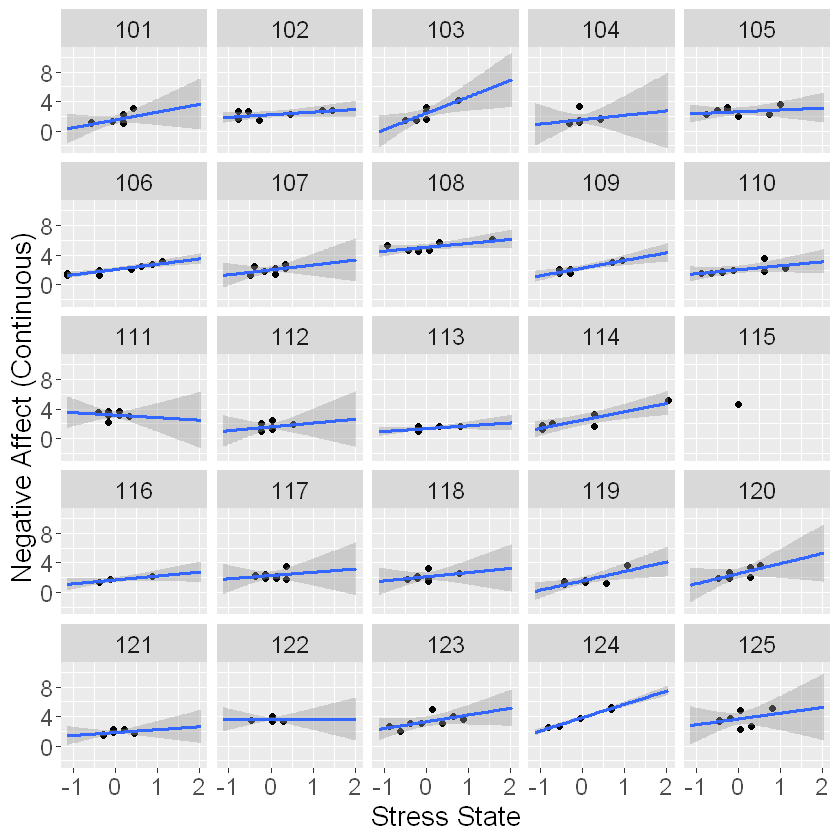

In [9]:
#faceted plot
ggplot(data=ddata_long[which(ddata_long$id <= 125),], aes(x=stress_state,y=negaff)) +
  geom_point() +
  stat_smooth(method="lm", fullrange=TRUE) +
  xlab("Stress State") + ylab("Negative Affect (Continuous)") + 
  facet_wrap( ~ id) +
  theme(axis.title=element_text(size=16),
        axis.text=element_text(size=14),
        strip.text=element_text(size=14))

# 混合效应模型


我们使用 "lme4" 包来拟合混合效应模型，以及一些辅助的R包： "lmerTest" 提供了用于获取 参数检验的 p-vlaues 的工具；
"effects"包提供了用于计算和绘制基于模型的预测的工具；"interactions" 提供了绘制和探测交互效应的工具。

lme4 提供了函数 lmer ， 它用于拟合多层数据模型，或者是混合效应模型。 它的第一个参数是data， 输入你的原始数据，
na.action 参数用于指定对缺失值的处理方法。

## 零模型

模型里面没有自变量， 或者没有我们关心的变量， 所以这种模型叫0模型。
零模型可以被称为   unconditional means model ， 它用于考察因变量的方差有多少来自被试内， 有多少来自被试间。

In [10]:
#unconditional means model
model0_fit <- lmer(formula = negaff ~ 1 + (1|id), 
              data=ddata_long,
              na.action=na.exclude)
summary(model0_fit)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: negaff ~ 1 + (1 | id)
   Data: ddata_long

REML criterion at convergence: 3833.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8739 -0.6123 -0.1608  0.4658  3.9394 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept) 0.4270   0.6535  
 Residual             0.6627   0.8141  
Number of obs: 1441, groups:  id, 190

Fixed effects:
             Estimate Std. Error        df t value Pr(>|t|)    
(Intercept)   2.46368    0.05229 185.80793   47.12   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

In [11]:

# 我们使用 VarCorr 函数提取方差 ， id这一行对应的是被试内方差， Residual对应的是残差方差（不可以被被试差异所解释的方差
VarCorr(model0_fit)

 Groups   Name        Std.Dev.
 id       (Intercept) 0.65347 
 Residual             0.81408 

我们来计算组间相关性（ICC）， 它指的是被试内方差占总方差的比率， 如公式：

$ ICC_{between} = \frac{\sigma^{2}_{u0}}{\sigma^{2}_{u0} + \sigma^{2}_{e}} $

我们首先取药提取得到随机效应的方差， 我们将结果保存到数据框中， 方便提取数据， 毕竟数据框是我们在R中最熟悉的数据给格式。

In [12]:
randEffs <- as.data.frame(VarCorr(model0_fit))
randEffs

grp,var1,var2,vcov,sdcor
<chr>,<chr>,<chr>,<dbl>,<dbl>
id,(Intercept),NA,0.4270294,0.6534749
Residual,NA,NA,0.6627260,0.8140798


根据上面的公式， 可以计算得到ICC：

In [13]:
u0v = randEffs[1,4]
ev = randEffs[2,4]

icc <- u0v / (u0v+ev)
icc

[1] 0.391858

根据无条件均值模型计算ICC，结果表明，在负面情绪的总方差中，39.19%归因于人与人之间的差异，60.81%归因于人内差异。
这意味着使用随时间变化的变量作为预测变量时， 存在很大一部分人内方差， 着意味着我们构建多层模型、混合效应模型是非常有必要的。
专家建议ICC超过0.05（5%）时就应该考虑使用混合效应模型。

## 混合效应模型的构建

我们在模型里纳入了很多自变量， 我们一一解释：

- 1 : 这是常数项
- day ： 我们的因变量时随时间变化的， 所以纳入了时间day
- stress_trait_c ： 这是压力特质变量， 其实是被试每天的压力的平均值来代表它的压力特质， 而 stress_trait_c 是压力特质中心化的变量， 为什么要做中心化？ 因为我们需要把它作为调节变量
- stress_state ： 这个变量也是经过处理的， 是每日的压力值减去了被试均值， 意思是这个变量是经过了被试内的中心化， 所以这个变量代表了被试压力偏离他的均值的多少
- stress_state:stress_trait_c ： 调节项， stress_state对消极情绪的影响大小可能受到stress_trait_c的影响
- (1 + stress_state|id) ： 这是混合效应模型中定义随机效应的方法， 这种写法含义是 模型的截距和stress_state的效应都随id的不同而不同， id是被试id

In [15]:
model1 <- lmer(formula = negaff ~ 1 + day + stress_trait_c + 
                      stress_state + stress_state:stress_trait_c + 
                      (1 + stress_state|id), 
                    data=ddata_long,
                    na.action=na.exclude)
summary(model1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
negaff ~ 1 + day + stress_trait_c + stress_state + stress_state:stress_trait_c +  
    (1 + stress_state | id)
   Data: ddata_long

REML criterion at convergence: 3162.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5368 -0.6127 -0.0729  0.5093  4.4164 

Random effects:
 Groups   Name         Variance Std.Dev. Corr
 id       (Intercept)  0.2135   0.4621       
          stress_state 0.1257   0.3546   0.53
 Residual              0.4038   0.6355       
Number of obs: 1438, groups:  id, 190

Fixed effects:
                              Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                  2.695e+00  4.583e-02  3.922e+02  58.806   <2e-16
day                         -6.580e-02  7.552e-03  1.250e+03  -8.713   <2e-16
stress_trait_c               1.038e+00  7.946e-02  1.859e+02  13.067   <2e-16
stress_state                 7.647e-01  4.561e-02  1.664e+02  16.

### 结果解读

#### 固定效应 Fixed Effects:

- (Intercept):  他是模型中所有变量取0时， 因变量的值， 具体到这个模型， 你可以说在第0天被试的平均消极情是2.695
- day: 在调研的这几天里， 被试的消极情绪随时间逐渐降低， 每过一天， 消极情绪降低-6.580e-02
- stress_trait_c： 压力特质比较高的被试具有较多的消极情绪， 压力特质增加一个单位消极情绪增加1.308
- stress_state  : 被试当天感受到的压力越多他的消极情绪越多， 压力增加1个单位消极情绪增加0.76
- stress_trait_c:stress_state ： 交互效应不显著(0.16, p = 0.11)， 这意味着stress_trait的效应量不受stress_trait_c的影响， 意味着被试的压力特质对压力状态和消极情绪的调节效应不显著

#### 随机效应 Random Effects:

- sd((Intercept)): 每个被试的模型截距不同， 而这个截距的方差就是 0.2135
- sd(stress_state)： stress_state 对 因变量 消极情绪的效应不是固定不变的， 这个效应随被试不同而不同， 而这种被试导致的效应的方差是 0.1257 
- Corr ： Intercept 和 stress_state 是两个随机变量， 这两个随机变量的相关系数是 0.53， 这个相关系数较大， 意味着被试预期的消极情绪越大， stress_state 对消极情绪的影响也越大

### 预测值

基于样本数据和已有模型， 可以估计因变量的值， 也叫因变量的预测值， 如何获取因变量预测值：

In [16]:
# 保存模型的预测结果
ddata_long$pred_m1 <- predict(model1)
head(ddata_long)

,id,day,negaff,pss,stress,bfi_n,stress_trait,negaff_trait,bfi_n_c,stress_trait_c,stress_state,negaff_state,pred_m1
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>,<dbl>
1,101,0,3.0,2.50,1.50,2,1.0625,1.5,-0.9815789,-0.3330326,0.4375,1.5,2.122456
2,101,1,2.3,2.75,1.25,2,1.0625,1.5,-0.9815789,-0.3330326,0.1875,0.8,1.908520
3,101,2,1.0,3.50,0.50,2,1.0625,1.5,-0.9815789,-0.3330326,-0.5625,-0.5,1.398305
4,101,3,1.3,3.00,1.00,2,1.0625,1.5,-0.9815789,-0.3330326,-0.0625,-0.2,1.628788
5,101,4,1.1,2.75,1.25,2,1.0625,1.5,-0.9815789,-0.3330326,0.1875,-0.4,1.711131
6,101,5,1.0,2.75,1.25,2,1.0625,1.5,-0.9815789,-0.3330326,0.1875,-0.5,1.645335


### 获取参数的置信区间

可以使用confint函数获取参数的置信区间， 但是结果比较难看懂， 因为里面很多参数是我们不熟悉的（sig01， sig02 等），
因为这些参数的名字其实是来自于模型的推导中用到的， 你没有深入了解过混合效应模型的参数估计方法， 你可能看不懂，
不过， 我们只能试着让你有一个感性认识：

- .sig01 随机截距的标准差， 如果你想获得方差的置信区间， 只需要把这个值平方一下
- sig02 随机截距和随机斜率的相关系数
- sig03 随机斜率的标准差
- sigma 残差标准差 

In [17]:
confint(model1)

Computing profile confidence intervals ...



,2.5 %,97.5 %
.sig01,0.40390297,0.52245693
.sig02,0.27635505,0.77129752
.sig03,0.25230527,0.45069358
.sigma,0.60962930,0.66244352
(Intercept),2.60530435,2.78468853
day,-0.08058845,-0.05099124
stress_trait_c,0.88249219,1.19390741
stress_state,0.67339998,0.85449747
stress_trait_c:stress_state,-0.03788643,0.34703329


## 可视化

先看被试层面的变量， negaff_trait 是消极情绪特质， 其实就是每天的消极情绪取被试内的均值， 代表了被试每天的平均消极情绪，
这个变量很可能受到压力特质（被试每天压力状态的一个被试内均值）的影响， 因此可以绘制这两个变量的关系：

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."
`geom_smooth()` using formula = 'y ~ x'


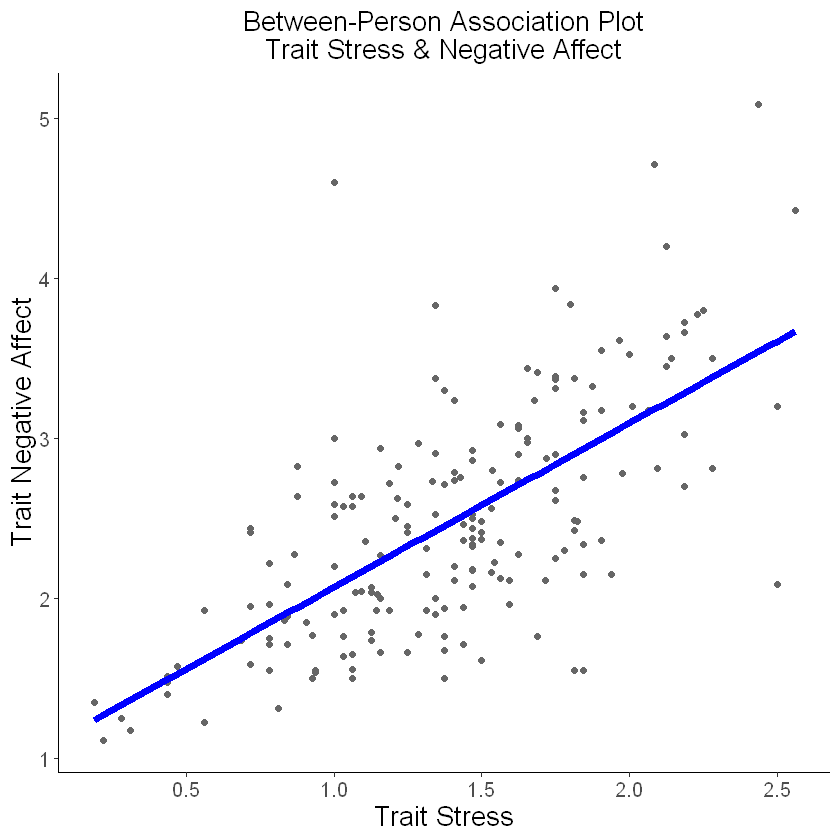

In [18]:
ggplot(data=personmeans, aes(x=stress_trait, y=negaff_trait, group=factor(id)), legend=FALSE) +
  geom_point(colour="gray40") +
  geom_smooth(aes(group=1), method=lm, se=FALSE, fullrange=FALSE, lty=1, size=2, color="blue") +
  xlab("Trait Stress") + ylab("Trait Negative Affect") +
  theme_classic() +
  theme(axis.title=element_text(size=16),
        axis.text=element_text(size=12),
        plot.title=element_text(size=16, hjust=.5)) +
  ggtitle("Between-Person Association Plot\nTrait Stress & Negative Affect")

下面绘制negaff_state和stress_state的关系 ， 因为这两个变量都是日测数据， 因此每个被试都应当是不同的。


`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 20 rows containing non-finite values (`stat_smooth()`)."
`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 20 rows containing non-finite values (`stat_smooth()`)."


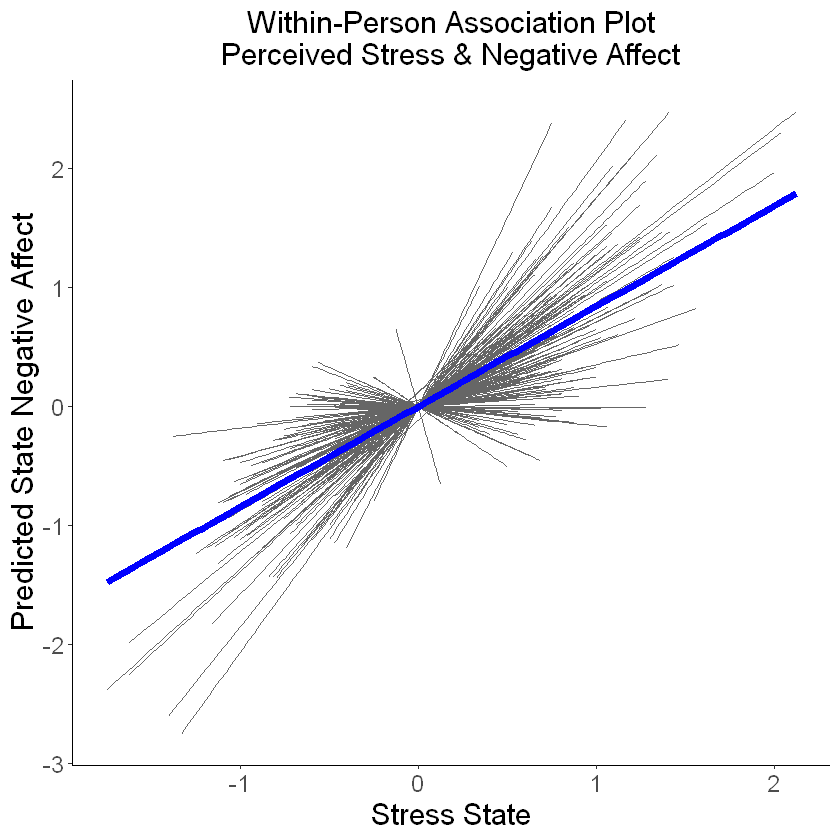

In [18]:
ggplot(data=ddata_long, aes(x=stress_state, y=negaff_state, group=factor(id), colour="gray"), legend=FALSE) +
  geom_smooth(method=lm, se=FALSE, fullrange=FALSE, lty=1, size=.5, color="gray40") +
  geom_smooth(aes(group=1), method=lm, se=FALSE, fullrange=FALSE, lty=1, size=2, color="blue") +
  xlab("Stress State") + ylab("Predicted State Negative Affect") +
  theme_classic() +
  theme(axis.title=element_text(size=18),
        axis.text=element_text(size=14),
        plot.title=element_text(size=18, hjust=.5)) +
  ggtitle("Within-Person Association Plot\nPerceived Stress & Negative Affect")

## 增加神经质变量作为预测变量

bfi_n_c 是大五人格量表中的神经质变量， 它经过处理得到了中心化后的变量， 
这个变量中心化的目的也是因为这个变量会参与调节效应， 构建模型如下：

In [21]:
# fit model
model2 <- lmer(formula = negaff ~ 1 + day + stress_trait_c + 
                      bfi_n_c + stress_trait_c:bfi_n_c +
                      stress_state + stress_state:stress_trait_c + 
                      stress_state:bfi_n_c + stress_state:stress_trait_c:bfi_n_c + 
                      (1 + stress_state|id),
                    data=ddata_long,
                    na.action=na.exclude)
#Look at results
summary(model2)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
negaff ~ 1 + day + stress_trait_c + bfi_n_c + stress_trait_c:bfi_n_c +  
    stress_state + stress_state:stress_trait_c + stress_state:bfi_n_c +  
    stress_state:stress_trait_c:bfi_n_c + (1 + stress_state |      id)
   Data: ddata_long

REML criterion at convergence: 3161.8

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.4271 -0.6011 -0.0749  0.5045  4.4732 

Random effects:
 Groups   Name         Variance Std.Dev. Corr
 id       (Intercept)  0.1955   0.4422       
          stress_state 0.1238   0.3518   0.51
 Residual              0.4040   0.6356       
Number of obs: 1438, groups:  id, 190

Fixed effects:
                                      Estimate Std. Error         df t value
(Intercept)                          2.690e+00  4.556e-02  3.944e+02  59.055
day                                 -6.545e-02  7.572e-03  1.247e+03  -8.644
stress_trait_c                       9.

### 结果解读

#### 固定效应

- (Intercept): 截距项， stress_trait_c  和 bfi_n_c 都取0的时候（均值）， 因变量的期望是 2.69
- stress_trait_c ： 被试的压力特质越高， 感受到的消极情绪越多
- bfi_n_c ： 神经质得分越高的人感受到的消极情绪越多(0.15, p = 0)
- stress_state ： 当天感受压力越大， 当天的消极情绪越多（0.77， p=0）
- stress_trait_c:bfi_n_c ： 神经质对压力特质的调节效应不显著(0.04, p = 0.64)
- stress_trait_c:stress_state ： 压力特质对日间压力状态没有调节效应(0.13, p = 0.22)
- bfi_n_c:stress_state: 神经质对日间压力状态没有调节效应(0.08, p = 0.12)
- stress_trait_c:bfi_n_c:stress_state： 神经质对压力特质和压力状态的调节效应的调节作用不显著

#### 随机效应

与之前的结论一致， 在此略去


获取模型预测值

In [22]:
ddata_long$pred_m2 <- predict(model2)
head(ddata_long)

,id,day,negaff,pss,stress,bfi_n,stress_trait,negaff_trait,bfi_n_c,stress_trait_c,stress_state,negaff_state,pred_m1,pred_m2
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>",<dbl>,<dbl>,<dbl>,<dbl>
1,101,0,3.0,2.50,1.50,2,1.0625,1.5,-0.9815789,-0.3330326,0.4375,1.5,2.122456,2.097006
2,101,1,2.3,2.75,1.25,2,1.0625,1.5,-0.9815789,-0.3330326,0.1875,0.8,1.908520,1.888382
3,101,2,1.0,3.50,0.50,2,1.0625,1.5,-0.9815789,-0.3330326,-0.5625,-0.5,1.398305,1.393416
4,101,3,1.3,3.00,1.00,2,1.0625,1.5,-0.9815789,-0.3330326,-0.0625,-0.2,1.628788,1.614307
5,101,4,1.1,2.75,1.25,2,1.0625,1.5,-0.9815789,-0.3330326,0.1875,-0.4,1.711131,1.692027
6,101,5,1.0,2.75,1.25,2,1.0625,1.5,-0.9815789,-0.3330326,0.1875,-0.5,1.645335,1.626575


## 调节效应的绘制

根据上面的结果，stress_state:bfi_n_c的调节效应是显著的， 意味着我们有必要进一步将调节效应可视化，
通常我们有两种可视化调节效应的方法， 1是选点法， 就是自变量和调节变量选择 M±SD 的值作为点， 绘制在不同调节变量取值下， 自变量与因变量的关系；
另一种方法是绘制JN图，它可以看到调节变量取值什么范围内， 自变量对因变量的效应是显著的。

## 选点法

我们先看下自变量和调节变量的描述性统计， 因为我们需要用到均值和标准差。

In [24]:
describe(ddata_long$bfi_n_c)
describe(ddata_long$stress_state)

,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,1,1458,-0.01210021,0.9564619,0.01842105,0.002582012,1.4826,-1.981579,2.018421,4,-0.07586913,-0.7908849,0.02504891


,vars,n,mean,sd,median,trimmed,mad,min,max,range,skew,kurtosis,se
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X1,1,1445,2.378342e-18,0.4943735,-0.03125,-0.01547413,0.4633125,-1.75,2.125,3.875,0.3580108,0.7924172,0.01300533


我们使用 effect 函数来计算不同自变量和调节变量取值下因变量的值， effect 函数的term参数就是你关注的交互项，即自变量和调节变量的乘积。
mod 参数就是我们之前拟合得到的模型； xlevels 用于设置选点值， 比如自变量stress_state的正负一个标准差的值就是c(-0.49,+0.49) 。

In [25]:
#calculate effect
effects_model2 <- effect(term="bfi_n_c*stress_state", mod=model2,xlevels=list(bfi_n_c=c(-0.96, +0.96), stress_state=c(-0.49,+0.49)))
summary(effects_model2)

NOTE: bfi_n_c:stress_state is not a high-order term in the model

Warning message in Analyze.model(focal.predictors, mod, xlevels, default.levels, :
"the predictors stress_trait_c, bfi_n_c are one-column matrices that were converted to vectors"



 bfi_n_c*stress_state effect
       stress_state
bfi_n_c    -0.49     0.49
  -0.96 1.964450 2.644774
  0.96  2.188157 3.011998

 Lower 95 Percent Confidence Limits
       stress_state
bfi_n_c    -0.49     0.49
  -0.96 1.858012 2.510688
  0.96  2.080619 2.876440

 Upper 95 Percent Confidence Limits
       stress_state
bfi_n_c    -0.49     0.49
  -0.96 2.070889 2.778860
  0.96  2.295694 3.147556

这个结果输出的是自变量和调节变量不同取值下， 因变量的值； 同时输出了因变量值的95%置信区间。有了这些数据， 我们就可以绘制简单效应图。

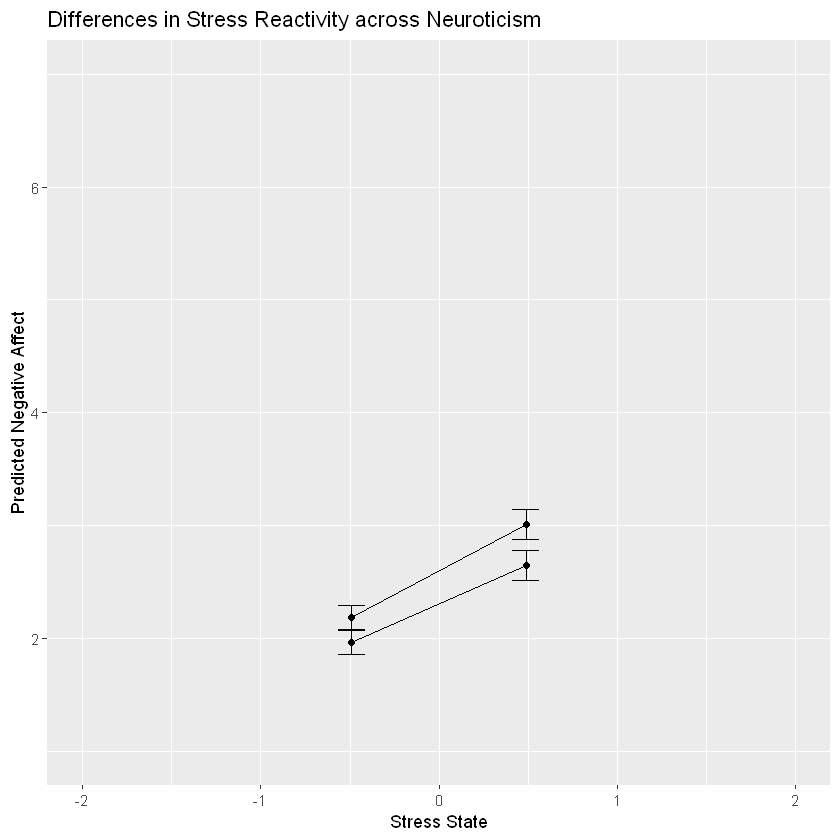

In [26]:
#convert to dataframe
effectsdata <- as.data.frame(effects_model2)
#plotting the effect evaluation (with standard error ribbon)
ggplot(data=effectsdata, aes(x=stress_state, y=fit, group=bfi_n_c), legend=FALSE) + 
  geom_point() +
  geom_line() +
  #geom_ribbon(aes(ymin=lower, ymax=upper), alpha=.3) +
  geom_errorbar(aes(ymin=lower, ymax=upper), width=.15) +
  xlab("Stress State") + xlim(-2,2) +
  ylab("Predicted Negative Affect") + ylim(1,7) +
  ggtitle("Differences in Stress Reactivity across Neuroticism")

johnson_neyman 这个函数可以用于绘制 JN图 ， 关于这个图的原理可以看这篇文章[《Johnson-Neyman图原理和制作Excel工具分享》](https://mlln.cn/2023/08/23/Johnson-Neyman%E5%9B%BE%E5%8E%9F%E7%90%86%E5%92%8C%E5%88%B6%E4%BD%9CExcel%E5%B7%A5%E5%85%B7%E5%88%86%E4%BA%AB/)， 并且这篇文章介绍了[如何使用excel绘制JN图](https://mlln.cn/2023/08/23/Johnson-Neyman%E5%9B%BE%E5%8E%9F%E7%90%86%E5%92%8C%E5%88%B6%E4%BD%9CExcel%E5%B7%A5%E5%85%B7%E5%88%86%E4%BA%AB/)。

JOHNSON-NEYMAN INTERVAL 

When bfi_n_c is INSIDE the interval [-4.45, 40.14], the slope of
stress_state is p < .05.

Note: The range of observed values of bfi_n_c is [-1.98, 2.02]


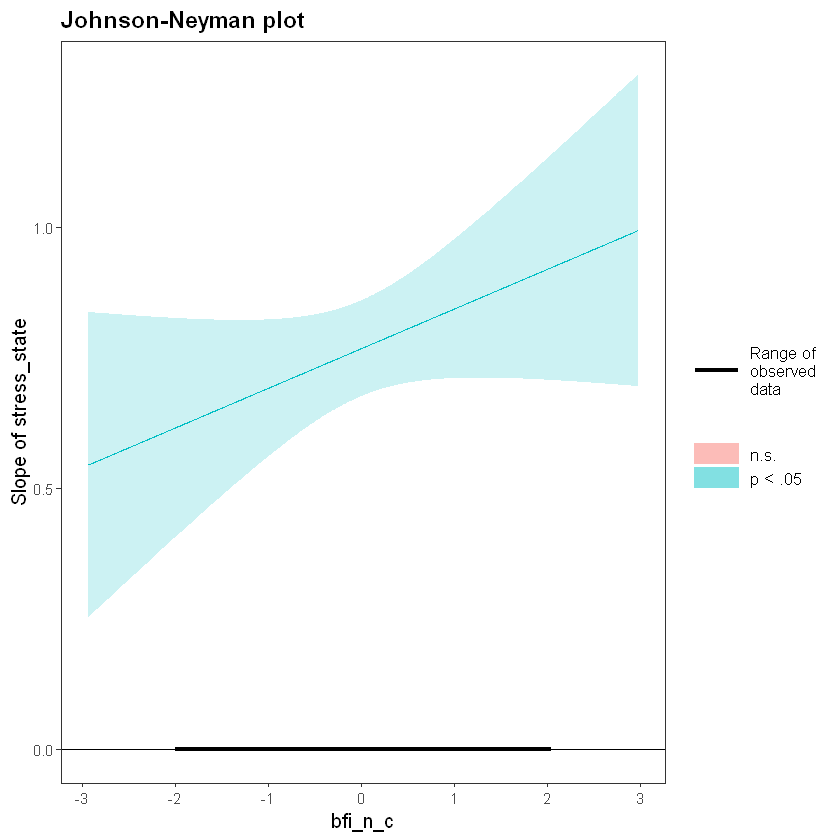

In [33]:
johnson_neyman(model=model2, pred=stress_state, modx=bfi_n_c)

# 一些有用函数

In [29]:
BIC(logLik(model2))

[1] 3256.299

In [31]:
logLik(logLik(model2))

'log Lik.' -1580.888 (df=13)

In [32]:
BIC(logLik(model2))

[1] 3256.299

# 数据下载

本教程所有用到的代码和数据都可以在这里下载。